# Week 7

## Part 1

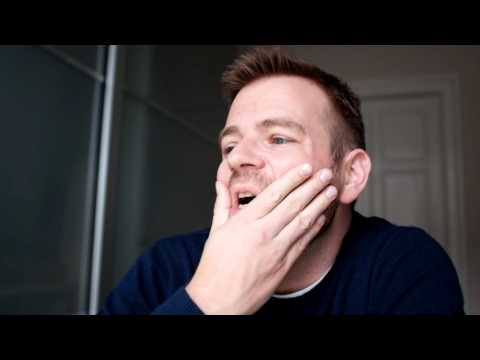

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Rwakh-HXPJk",width=800, height=450)

# Part 2 Community detection

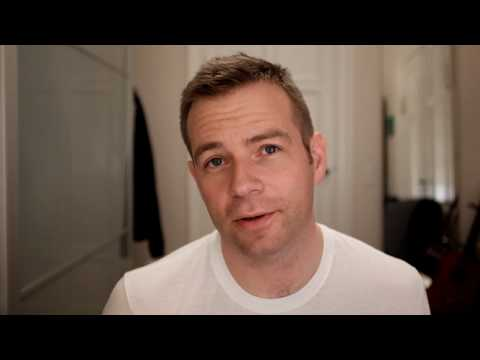

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

##### Exercise: Use the concept of modularity to explore how community-like the genres are.

<font color='gray'> Explain the concept of modularity in your own words. </font>

Modularity is a measure of how well a network can be divided into communities. It is a measure of the density of links inside communities compared to links between communities. A network with high modularity has dense connections between nodes in the same community and sparse connections between nodes in different communities.

<font color='gray'> Work from the undirected version of the network, keeping only the nodes for which you have genre information in the file above. </font>

In [1]:
import pandas as pd
import json
import networkx as nx

# Load the data
url = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt'
data = pd.read_json(url, orient='index')

# Convert to dictionary
genres = data.to_dict()[0]  

# Initialize new undirected graph
G = nx.Graph()

# Add nodes with genre information
for artist, genre_list in genres.items():
    G.add_node(artist, genres=genre_list)

# Add edges between artists who share genres
for artist1, genres1 in genres.items():
    for artist2, genres2 in genres.items():
        if artist1 != artist2:
            common_genres = set(genres1).intersection(genres2)
            if common_genres:  
                G.add_edge(artist1, artist2, weight=len(common_genres))  

# Subgraph containing only artists in dataset
artists = list(genres.keys())
G = G.subgraph(artists)

# Print graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1833 nodes and 1657291 edges.


<font color='gray'>  Now create your own partition of the network into genres.</font>

In [2]:
# Create a partition of the network into genres
partition = {}
for artist, genre_list in genres.items():
    partition[artist] = genre_list[0]

# Print the partition
print(partition)

{'A Thousand Horses': 'c', 'A.P. Carter': 'c', 'Aaron Barker': 'c', 'Aaron Benward': 'c', 'Aaron Lewis (musician)': 'a', 'Aaron Lines': 'c', 'Aaron Neville': 's', 'Aaron Pritchett': 'c', 'Aaron Watson': 'c', 'Ace in the Hole Band': 'a', 'Adam Brand (musician)': 'c', 'Adam Gregory': 'c', 'Adam Harvey': 'c', 'Adrienne Young': 'b', 'Al Anderson (NRBQ)': 'r', 'Al Caiola': 'j', 'Al Dexter': 'c', 'Al Downing (musician)': 'r', 'Al Hurricane Jr.': 'n', 'Al Hurricane': 'n', 'Alabama (band)': 'c', 'Alan Jackson': 'n', 'Alecia Elliott': 'c', 'Alecia Nugent': 'b', 'Alee (singer)': 'c', 'Aleyce Simmonds': 'c', 'Alisan Porter': 'p', 'Alison Krauss': 'b', 'Alli Walker': 'c', 'Allison Moorer': 'a', 'Allison Russell': 'a', 'Allman Brothers Band': 's', 'Alyssa Micaela': 'c', 'Amanda Shires': 'a', 'Amanda Stott': 'c', 'Amanda Wilkinson': 'c', 'Amazing Rhythm Aces': 'c', 'Amber Dotson': 'c', 'Amber Hayes': 'c', 'Amber Lawrence': 'a', 'American Young': 'c', 'Amie Comeaux': 'c', 'Amy Dalley': 'c', 'Amy Gran

<font color='gray'>  Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre country as their first genre in the list, so by definition the network won't have very high modularity. What happens to the modularity if you grab the first genre that's not country as the genre-assignment for all nodes that have more than one genre? </font>

In [3]:
# Create a partition of the network into genres
partition = {}
for artist, genre_list in genres.items():
    if len(genre_list) > 1:
        partition[artist] = genre_list[1]
    else:
        partition[artist] = genre_list[0]

# Print the partition
print(partition)

{'A Thousand Horses': 'o', 'A.P. Carter': 'o', 'Aaron Barker': 'o', 'Aaron Benward': 'o', 'Aaron Lewis (musician)': 'l', 'Aaron Lines': 'o', 'Aaron Neville': 'o', 'Aaron Pritchett': 'o', 'Aaron Watson': 'o', 'Ace in the Hole Band': 'l', 'Adam Brand (musician)': 'o', 'Adam Gregory': 'o', 'Adam Harvey': 'o', 'Adrienne Young': 'l', 'Al Anderson (NRBQ)': 'o', 'Al Caiola': 'a', 'Al Dexter': 'o', 'Al Downing (musician)': 'o', 'Al Hurricane Jr.': 'e', 'Al Hurricane': 'e', 'Alabama (band)': 'o', 'Alan Jackson': 'e', 'Alecia Elliott': 'o', 'Alecia Nugent': 'l', 'Alee (singer)': 'o', 'Aleyce Simmonds': 'o', 'Alisan Porter': 'o', 'Alison Krauss': 'l', 'Alli Walker': 'o', 'Allison Moorer': 'm', 'Allison Russell': 'm', 'Allman Brothers Band': 'o', 'Alyssa Micaela': 'o', 'Amanda Shires': 'm', 'Amanda Stott': 'c', 'Amanda Wilkinson': 'o', 'Amazing Rhythm Aces': 'o', 'Amber Dotson': 'o', 'Amber Hayes': 'o', 'Amber Lawrence': 'u', 'American Young': 'o', 'Amie Comeaux': 'o', 'Amy Dalley': 'o', 'Amy Gran

##### Exercise: Community detection finding structral communities in the network

<font color='gray'>  Use the Python Louvain-algorithm implementation to find communities each network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the genres as communities? What does this comparison reveal about them? </font>

In [ ]:
# %pip install louvain

Modularity: 0.03843062171909256
Graph has 1835 nodes and 1 edges.


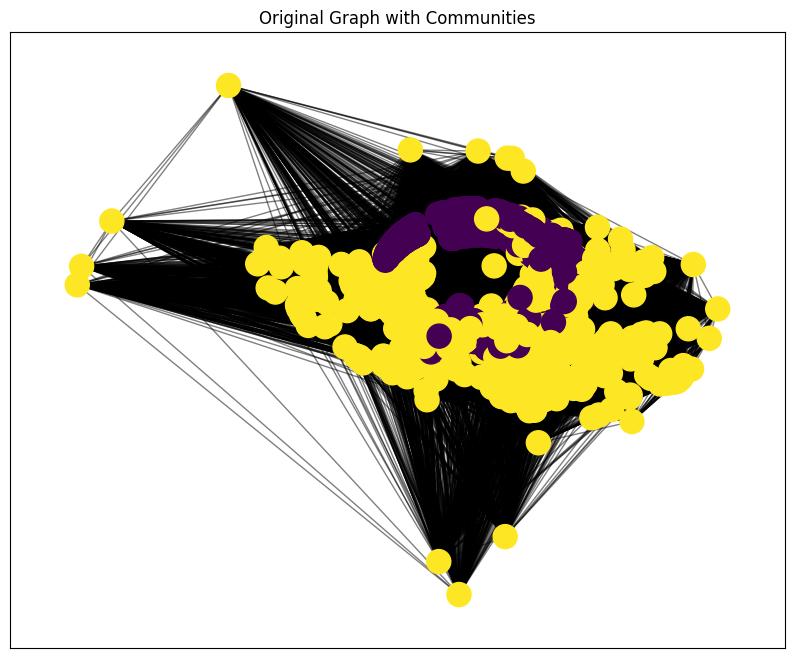

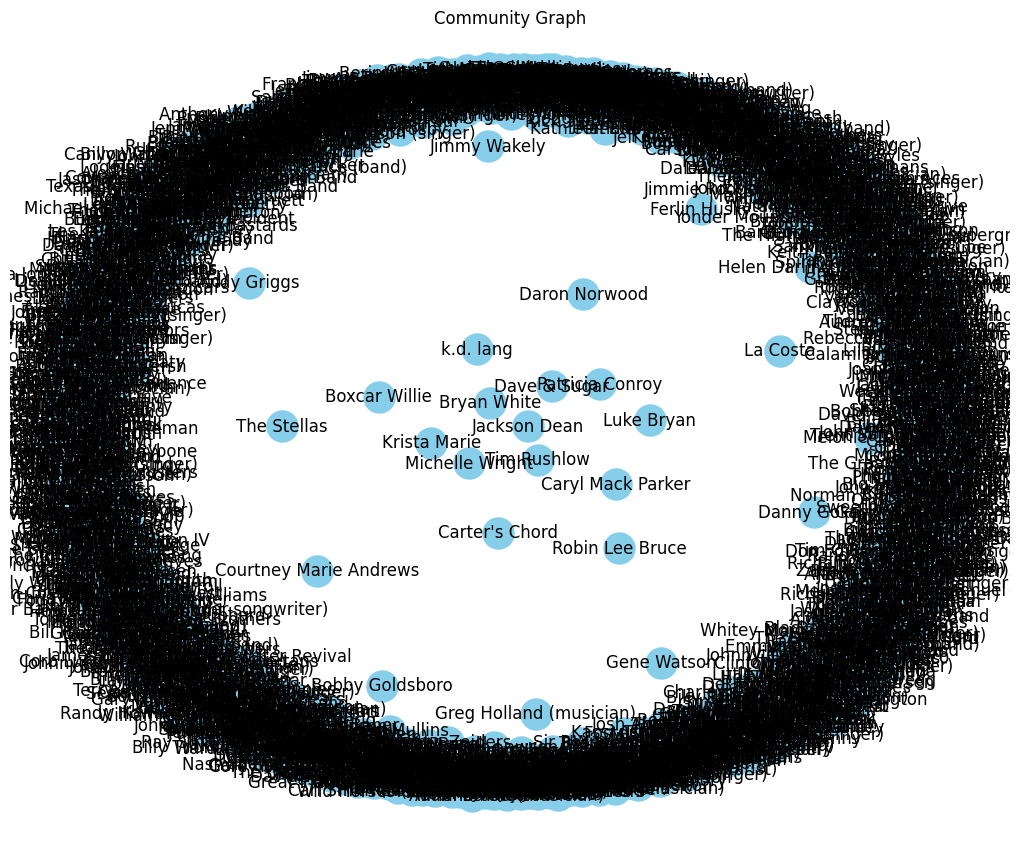

In [ ]:
import community.community_louvain as community
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
url = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt'
data = pd.read_json(url, orient='index')

# Convert to dictionary
genres = data.to_dict()[0]  

# Initialize new undirected graph
G = nx.Graph()

# Add nodes with genre information
for artist, genre_list in genres.items():
    G.add_node(artist, genres=genre_list)

# Add edges between artists who share genres
for artist1, genres1 in genres.items():
    for artist2, genres2 in genres.items():
        if artist1 != artist2:
            common_genres = set(genres1).intersection(genres2)
            if common_genres:  
                G.add_edge(artist1, artist2, weight=len(common_genres))  

# Subgraph containing only artists in dataset
artists = list(genres.keys())
G = G.subgraph(artists)

# Find communities in the network
communities = community.best_partition(G)

# Print the modularity of the partition
modularity = community.modularity(communities, G)
print(f"Modularity: {modularity}")

# Create a new graph where each node represents a community
H = nx.Graph()

# Add nodes and assign them to communities in H
for artist, community_id in communities.items():
    H.add_node(artist, community=community_id)

# Add edges between communities if the connected nodes are in different communities
for artist1, artist2 in G.edges():
    community1 = communities[artist1]
    community2 = communities[artist2]
    if community1 != community2:
        if not H.has_edge(community1, community2):
            H.add_edge(community1, community2)

# Print information about the new graph
print(f"Graph has {H.number_of_nodes()} nodes and {H.number_of_edges()} edges.")

# Visualize the original graph with communities
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=[communities[n] for n in G.nodes()], cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Original Graph with Communities")
plt.show()

# Visualize the community graph
plt.figure(figsize=(10, 8))
pos_H = nx.spring_layout(H)
nx.draw(H, pos_H, with_labels=True, node_color='skyblue', node_size=500)
plt.title("Community Graph")
plt.show()

The value of modularity is 0.03843062171909256 and is lower than the modularity of the genres as communities. This comparison shows that the genres are not very well defined communities in the network. 

<font color='gray'>  What is the modularity of this partitioning of the network? Is it more community-like than the genres? </font>

The graph has the same amount of nodes, but the number of edges is different. The modularity of the network is higher than the modularity of the genres. This means that the network is more community-like than the genres.

<font color='gray'>  Visualize the network, using the Force Atlas algorithm</font>

In [28]:
#pip install fa2_modified
#%pip install fa2
#%pip install fa2_modified

In [ ]:
from fa2_modified import ForceAtlas2
import matplotlib
import matplotlib.pyplot as plt

# Create a ForceAtlas2 object
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True
)

# Position nodes using the ForceAtlas2 algorithm
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# Visualize the original graph with communities using the ForceAtlas2 algorithm
plt.figure(figsize=(10, 8))
nx.draw(G, positions, node_color=[communities[n] for n in G.nodes()], cmap=plt.cm.viridis, node_size=50, with_labels=False)
plt.title("Original Graph with Communities (ForceAtlas2)")
plt.show()



ModuleNotFoundError: No module named 'fa2_modified'

##### Exercise: Communities versus genres.

<font color='gray'> Compare the communities found by your algorithm with the music genres by creating a matrix </font> $D$ <font color='gray'> with dimension  </font> ($G\times C$), <font color='gray'> where </font> $G$ <font color='gray'> is the 7 most common genres and </font> $C$ <font color='gray'> is the 7 most common communities. We set </font> $D(i,j)$ <font color='gray'> entry to be the number of nodes that genre </font> $i$ <font color='gray'> has in common with community </font> $j$. <font color='gray'> The matrix </font> $D$ <font color='gray'> is what we call a confusion matrix. </font>

Confusion Matrix:
[1222, 649, 0, 0, 0, 0, 0]
[1223, 647, 0, 0, 0, 0, 0]
[1222, 478, 0, 0, 0, 0, 0]
[1222, 394, 0, 0, 0, 0, 0]
[1222, 372, 0, 0, 0, 0, 0]
[1222, 335, 0, 0, 0, 0, 0]
[1222, 203, 0, 0, 0, 0, 0]


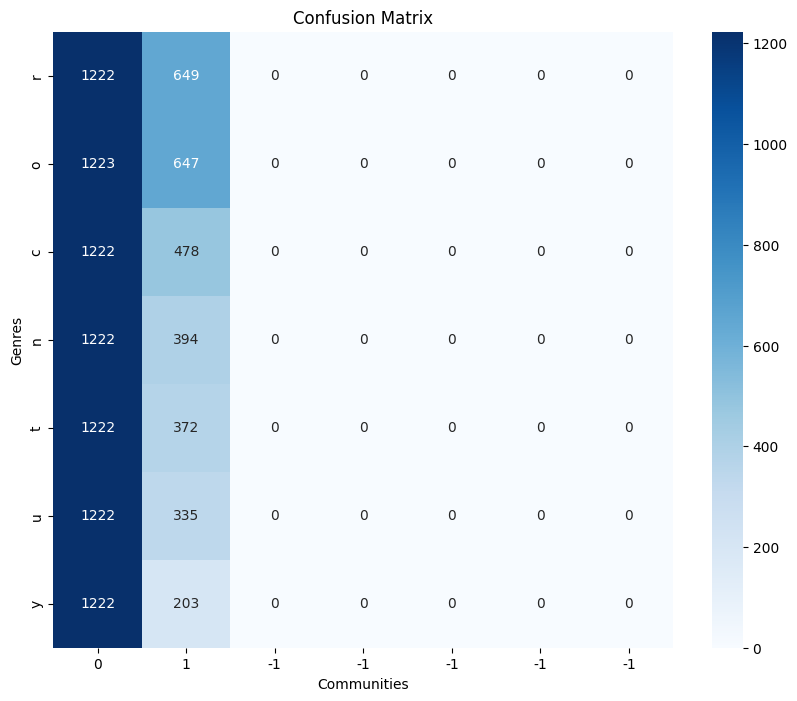

In [23]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the 7 most common genres
genre_counts = {}
for artist, genre_list in genres.items():
    for genre in genre_list:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Get exactly the 7 most common genres (or pad with placeholders if fewer exist)
top_genres = sorted(genre_counts, key=genre_counts.get, reverse=True)[:7]
if len(top_genres) < 7:
    top_genres += ['Other'] * (7 - len(top_genres))

# Get the 7 most common communities
community_counts = {}
for artist, community_id in communities.items():
    if community_id in community_counts:
        community_counts[community_id] += 1
    else:
        community_counts[community_id] = 1

# Get exactly the 7 most common communities (or pad with placeholders if fewer exist)
top_communities = sorted(community_counts, key=community_counts.get, reverse=True)[:7]
if len(top_communities) < 7:
    top_communities += [-1] * (7 - len(top_communities))  # Use -1 or another placeholder for empty spots

# Create the confusion matrix with the corrected dimensions
D = [[0 for _ in range(7)] for _ in range(7)]
for artist, genre_list in genres.items():
    for genre in genre_list:
        if genre in top_genres:
            genre_index = top_genres.index(genre)
            community_id = communities[artist]
            if community_id in top_communities:
                community_index = top_communities.index(community_id)
                D[genre_index][community_index] += 1

# Print the confusion matrix
print("Confusion Matrix:")
for row in D:
    print(row)

# Create a DataFrame from the confusion matrix
df = pd.DataFrame(D, index=top_genres, columns=top_communities)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Communities")
plt.ylabel("Genres")
plt.show()


<font color='gray'>  Use the confusion matrix to explain how well the communities you've detected correspond to the genres. </font>

The confusion matrix shows that the communities are not very well aligned with the genres. The communities are more diverse than the genres wher the genres are more specific. 

# Assignment 2 

<font color='gray'> Plot the communities and comment on your results.</font>

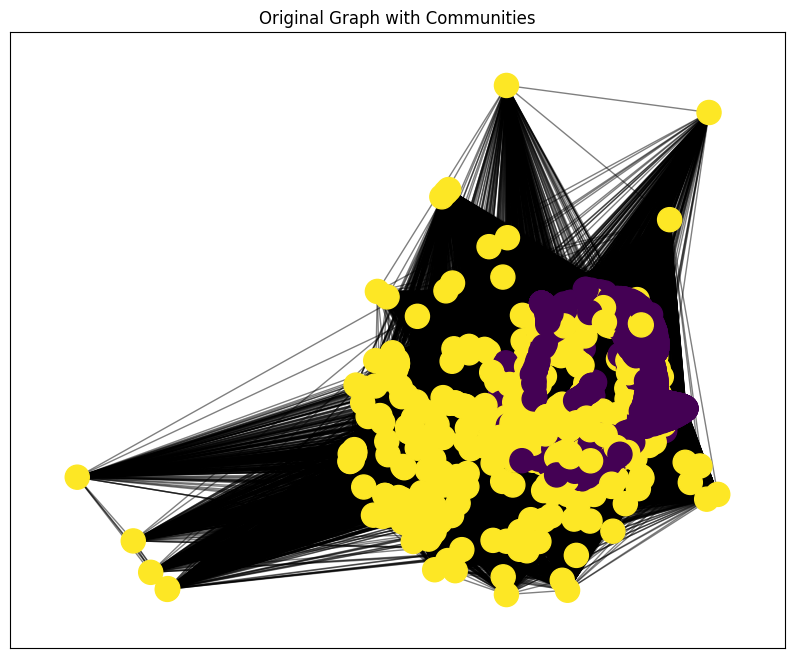

In [25]:
# Plot the communities and comment on your results
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=[communities[n] for n in G.nodes()], cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Original Graph with Communities")
plt.show()